In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

import json
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import math

from utils import *

Edit this next cell to choose a different country / year report:

In [5]:
# CHN_1_2013.json
# BGD_3_1988.5.json
# IND_1_1987.5.json
# ARG_2_1987.json
# EST_3_1998.json
#   Minimum (spline vs GQ)	computed =       19.856	given =       75.812	difference = 73.809%
#   Maximum (spline vs GQ)	computed =       4974.0	given =      11400.0	difference = 56.363%
with open("../jsoncache/CHN_1_2005.json","r") as f:
    d = json.loads(f.read())
    
for k in d['dataset']:
    print(k.ljust(20),d['dataset'][k])

coverage             Rural
format               Grouped
timespan             UnDefined
year                 2005
source               CHN_R2005X
country              China
iso3c                CHN
measure              Consumption


These next few conversions don't really work. The PPP data field seems wrong.

In [6]:
# Check poverty line conversion
DAYS_PER_MONTH = 30.4167
line_month_ppp_given = d['inputs']['line_month_ppp']
print("Poverty line (PPP):", line_month_ppp_given)

Poverty line (PPP): 57.7917


In [7]:
# Check data mean
sample_mean_ppp_given = d['inputs']['mean_month_ppp']
print("Data mean (PPP):", sample_mean_ppp_given)

#implied_ppp = d['sample']['mean_month_lcu'] / d['sample']['mean_month_ppp']
#print("Implied PPP:", implied_ppp, "cf.", ppp)

Data mean (PPP): 100.331


Gini can be calculated directly from $L(p)$, although the reported Gini is modelled.

In [8]:
# Load the Lorenz curve
lorenz = pd.DataFrame(d['lorenz'])
lorenz = lorenz.drop("index",1)
lorenz = lorenz.append(pd.DataFrame({"L": 0, "p": 0}, index = [-1]))
lorenz = lorenz.sort_values("p")

lorenz['dp'] = lorenz.p.shift(-1)[:-1] - lorenz.p[:-1]
lorenz['dL'] = lorenz.L.shift(-1)[:-1] - lorenz.L[:-1]
lorenz['dLdp'] = lorenz.dL / lorenz.dp

# Now, F(y) = inverse of Q(p)
lorenz['y'] = lorenz.dLdp * sample_mean_ppp_given

# Calc and compare Ginis
G_calc = 1 - sum(0.5 * lorenz.dp[:-1] * (lorenz.L.shift(-1)[:-1] + lorenz.L[:-1])) / 0.5
G_given = d['dist']['Gini'] / 100.0
myassert("Empirical Gini:",G_calc, G_given)

Empirical Gini:     	computed =       0.3526	given =       0.3585	difference = 1.639%


## General Quadratic

General quadratic lorenz curve is estimated as ([Villasenor & Arnold, 1989](http://www.sciencedirect.com/science/article/pii/0304407689900894))
$$
L(1-L) = a(p^2 - L) + bL(p-1) + c(p-L)
$$
First we examine the basic regression diagnostics

In [9]:
lorenz['GQ_lhs'] = lorenz.L * (1 - lorenz.L)
lorenz['GQ_A']   = lorenz.p*lorenz.p - lorenz.L
lorenz['GQ_B']   = lorenz.L * (lorenz.p - 1)
lorenz['GQ_C']   = lorenz.p - lorenz.L

# Note: we exclude the endpoints of the Lorenz curve from estimation hence 1:-1
result = sm.OLS(lorenz.GQ_lhs[1:-1], lorenz.iloc[1:-1][['GQ_A','GQ_B','GQ_C']]).fit()

myassert("Ymean:", np.mean(lorenz[1:-1].GQ_lhs), d['quadratic']['reg']['ymean'])
myassert("SST:", result.centered_tss, d['quadratic']['reg']['SST'])
myassert("SSE:", result.ssr, d['quadratic']['reg']['SSE'])
myassert("MSE:", result.mse_resid, d['quadratic']['reg']['MSE'])
myassert("RMSE:", math.sqrt(result.mse_resid), d['quadratic']['reg']['RMSE'])
myassert("R^2:", result.rsquared, d['quadratic']['reg']['R2'])

Ymean:              	computed =       0.1247	given =       0.1247	difference = 0.0%
SST:                	computed =       0.1413	given =       0.1413	difference = 0.0%
SSE:                	computed =    4.577e-06	given =    4.577e-06	difference = 0.002%
MSE:                	computed =    3.521e-07	given =    3.521e-07	difference = 0.002%
RMSE:               	computed =    0.0005934	given =    0.0005934	difference = 0.001%
R^2:                	computed =          1.0	given =          1.0	difference = 0.002%


And the estimated coefficients

In [10]:
for param in ('A','B','C'):
    myassert(param+".coef:", result.params['GQ_'+param], d['quadratic']['reg']['params'][param]['coef'])
    myassert(param+".stderr:", result.bse['GQ_'+param], d['quadratic']['reg']['params'][param]['se'])
    myassert(param+".tval:", result.tvalues['GQ_'+param], d['quadratic']['reg']['params'][param]['t'])
    print()


A.coef:             	computed =       0.8205	given =       0.8205	difference = 0.0%
A.stderr:           	computed =     0.004547	given =     0.004547	difference = 0.002%
A.tval:             	computed =       180.44	given =       180.44	difference = 0.001%

B.coef:             	computed =      -1.1038	given =      -1.1038	difference = -0.0%
B.stderr:           	computed =      0.01983	given =      0.01983	difference = 0.0%
B.tval:             	computed =      -55.659	given =      -55.658	difference = -0.001%

C.coef:             	computed =       0.2475	given =       0.2475	difference = 0.0%
C.stderr:           	computed =      0.01012	given =      0.01013	difference = 0.003%
C.tval:             	computed =       24.443	given =       24.442	difference = 0.001%



Finally we can visualise what the distribution implied actually looks like

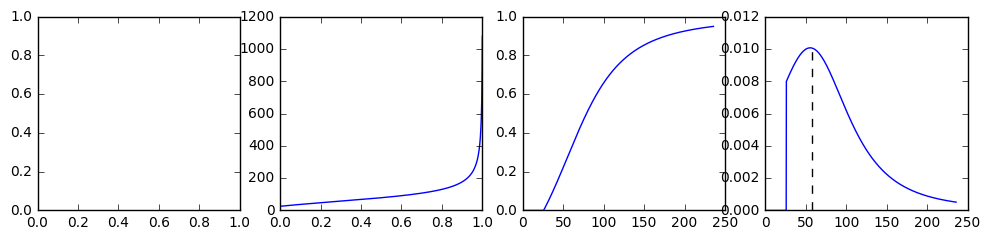

In [11]:
##########################################
plt.rcParams["figure.figsize"] = (12,2.5)
fig, ax = plt.subplots(1, 4)
##########################################
import scipy.integrate

a = d['quadratic']['reg']['params']['A']['coef']
b = d['quadratic']['reg']['params']['B']['coef']
c = d['quadratic']['reg']['params']['C']['coef']
mu = sample_mean_ppp_given
nu = -b * mu / 2
tau = mu * (4 * a - b**2) ** (1/2) / 2
eta1 = 2 * (c / (a + b + c + 1) + b/2) * (4 *a  - b**2)**(-1/2)
eta2 = 2 * ((2*a + b + c)/(a + c - 1) + b / a)*(4*a - b**2)**(-1/2)
lower = tau*eta1+nu
upper = tau*eta2+nu

# Hacky way to normalise
gq_pdf_integral = 1
gq_pdf = lambda y: (1 + ((y - nu)/tau)**2)**(-3/2) / gq_pdf_integral * (y >= lower) * (y <= upper)
gq_cdf = integral(gq_pdf, lower=lower)
gq_pdf_integral = gq_cdf(upper)
gq_quantile = inverse(gq_cdf, domain=(lower,upper))

ygrid = np.linspace(0, gq_quantile(0.95), 1000)
pgrid = np.linspace(0, 1, 1000)
themax = np.nanmax(gq_pdf(ygrid))
ax[1].plot(pgrid, gq_quantile(pgrid))
ax[2].plot(ygrid, gq_cdf(ygrid))
ax[3].plot(ygrid, gq_pdf(ygrid))
ax[3].vlines(x=d['inputs']['line_month_ppp'],ymin=0,ymax=themax,linestyle="dashed");

For comparison, here we also fit the spline model.

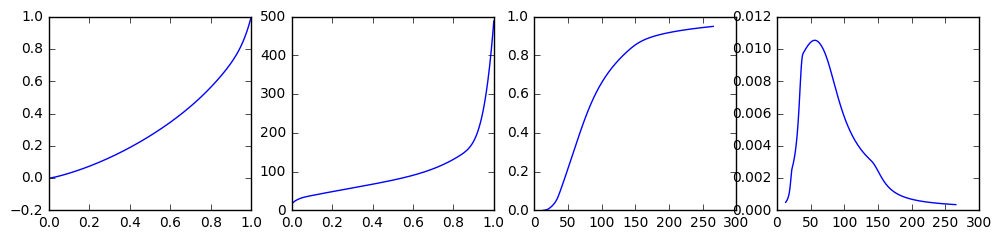

In [12]:
##########################################
plt.rcParams["figure.figsize"] = (12,2.5)
fig, ax = plt.subplots(1, 4)
##########################################

thehead = int(len(lorenz)*0.1)
themiddle = len(lorenz) - thehead - 2 - 2
lorenz.w = ([100, 100] + [10] * thehead) + ([1] * themiddle) + [1, 1]
#lorenz.w = [10]*thehead + [1]*(len(lorenz)-thehead)

lorenz_interp = scipy.interpolate.UnivariateSpline(lorenz.p,lorenz.L,w=lorenz.w,k=5,s=1e-6)
#lorenz_interp = scipy.interpolate.CubicSpline(lorenz.p, lorenz.L,bc_type=bc_natural)
quantile = lambda p: sample_mean_ppp_given * lorenz_interp.derivative()(p)
cdf = inverse(quantile)
pdf = derivative(cdf)

pgrid = np.linspace(0, 1, 1000)
ax[0].plot(pgrid, lorenz_interp(pgrid))
ax[1].plot(pgrid, quantile(pgrid))

ygrid = np.linspace(0, quantile(0.95), 1000)
ax[2].plot(ygrid, cdf(ygrid))
ax[3].plot(ygrid, pdf(ygrid));

Comparing the two

In [187]:
min_ceiling = (lorenz.L[0]-lorenz.L[-1])/(lorenz.p[0]-lorenz.p[-1])*sample_mean_ppp_given
max_floor = (lorenz.L[len(lorenz)-2]-lorenz.L[len(lorenz)-3])/(lorenz.p[len(lorenz)-2]-lorenz.p[len(lorenz)-3])*sample_mean_ppp_given
myassert("Minimum (GQ vs pts ceil)",lower,min_ceiling)
myassert("Minimum (spline vs pts ceil)",quantile(0),min_ceiling)
myassert("Maximum (GQ vs pts floor)",upper,max_floor)
myassert("Maximum (spline vs pts floor)",quantile(1),max_floor)

Minimum (GQ vs pts ceil)	computed =       87.845	given =       82.044	difference = 7.07%
Minimum (spline vs pts ceil)	computed =       51.868	given =       82.044	difference = 36.78%
Maximum (GQ vs pts floor)	computed =       3301.7	given =       1331.9	difference = 147.892%
Maximum (spline vs pts floor)	computed =       2012.8	given =       1331.9	difference = 51.119%


Model summary stats - TODO

In [188]:
myassert("SSE Lorenz:", result.ssr, d['quadratic']['summary']['sse_fitted']) #WRONG
# sse_up_to_hcindex


SSE Lorenz:         	computed =    3.984e-05	given =    6.935e-05	difference = 42.558%


Distribution statistics

In [189]:
HC_calc = float(gq_cdf(line_month_ppp_given))
HC_given = d['quadratic']['dist']['HC'] / 100.0
myassert("HC",HC_calc,HC_given)

median_calc = float(gq_quantile(0.5))
median_given = d['quadratic']['dist']['median_ppp']
myassert("Median",median_calc,median_given)

ZeroDivisionError: float division by zero

## Beta Lorenz

We find the estimating equation [here](https://www.imf.org/external/pubs/ft/wp/2011/wp11234.pdf) p. 29:
$$
\log(p - L) = \log(\theta) + \gamma \log(p) + \delta \log(1-p)
$$

[This book](http://documents.worldbank.org/curated/en/456591468740159687/pdf/multi-page.pdf) Kakwani (1980) is also cited but the above is not obvious within. Many papers cite Kakwani (1980)'s _Econometrica_ paper but that is clearly an incorrection citation as it's on a different topic.

In [13]:
# Generates warnings as endpoints shouldn't really be included in estimation
lorenz['beta_lhs'] = np.log(lorenz.p - lorenz.L)
lorenz['beta_A']   = 1
lorenz['beta_B']   = np.log(lorenz.p)
lorenz['beta_C']   = np.log(1-lorenz.p)

# Note: we exclude the endpoints of the Lorenz curve from estimation hence 1:-1
result = sm.OLS(lorenz.beta_lhs[1:-1], lorenz.iloc[1:-1][['beta_A','beta_B','beta_C']]).fit()

myassert("Ymean:", np.mean(lorenz[1:-1].beta_lhs), d['beta']['reg']['ymean'])
myassert("SST:", result.centered_tss, d['beta']['reg']['SST'])
myassert("SSE:", result.ssr, d['beta']['reg']['SSE'])
myassert("MSE:", result.mse_resid, d['beta']['reg']['MSE'])
myassert("RMSE:", math.sqrt(result.mse_resid), d['beta']['reg']['RMSE'])
myassert("R^2:", result.rsquared, d['beta']['reg']['R2'])


Ymean:              	computed =      -2.5913	given =      -2.5913	difference = -0.0%
SST:                	computed =       44.896	given =       44.896	difference = 0.0%
SSE:                	computed =    0.0008989	given =    0.0008989	difference = 0.001%
MSE:                	computed =    6.915e-05	given =    6.915e-05	difference = 0.001%
RMSE:               	computed =     0.008315	given =     0.008315	difference = 0.0%
R^2:                	computed =          1.0	given =          1.0	difference = 0.0%


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


In [14]:
for param in ('A','B','C'):
    myassert(param+".coef:", result.params['beta_'+param], d['beta']['reg']['params'][param]['coef'])
    myassert(param+".stderr:", result.bse['beta_'+param], d['beta']['reg']['params'][param]['se'])
    myassert(param+".tval:", result.tvalues['beta_'+param], d['beta']['reg']['params'][param]['t'])
    print()


A.coef:             	computed =      -0.4144	given =      -0.4144	difference = -0.0%
A.stderr:           	computed =     0.005426	given =     0.005426	difference = 0.0%
A.tval:             	computed =      -76.383	given =      -76.383	difference = -0.0%

B.coef:             	computed =       0.9589	given =       0.9589	difference = 0.0%
B.stderr:           	computed =     0.001435	given =     0.001435	difference = 0.001%
B.tval:             	computed =       668.28	given =       668.28	difference = 0.0%

C.coef:             	computed =       0.5059	given =       0.5059	difference = 0.0%
C.stderr:           	computed =     0.003398	given =     0.003397	difference = 0.001%
C.tval:             	computed =        148.9	given =        148.9	difference = 0.0%



In [15]:
theta = np.exp(result.params['beta_A'])
gamma = result.params['beta_B']
delta = result.params['beta_C']

myassert("Implied theta",theta,d['beta']['implied']['theta'])
myassert("Implied gamma",gamma,d['beta']['implied']['gamma'])
myassert("Implied delta",delta,d['beta']['implied']['delta'])

Implied theta       	computed =       0.6607	given =       0.6607	difference = 0.0%
Implied gamma       	computed =       0.9589	given =       0.9589	difference = 0.0%
Implied delta       	computed =       0.5059	given =       0.5059	difference = 0.0%


Now we can visualise the distribution. We calculate things numerically since the references are unclear on a closed-form expression.

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


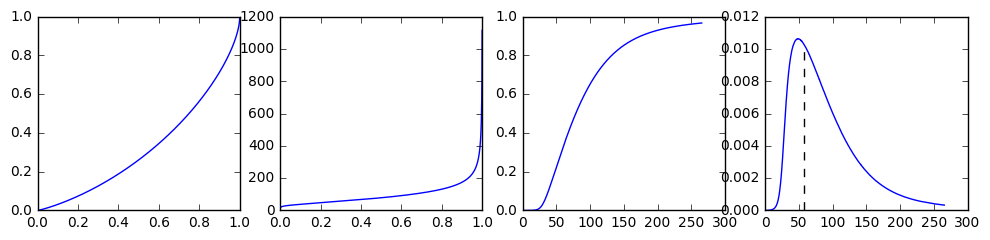

In [16]:
##########################################
plt.rcParams["figure.figsize"] = (12,2.5)
fig, ax = plt.subplots(1, 4)
##########################################

beta_lorenz = lambda p: p - theta * p ** gamma * (1 - p) ** delta
beta_quantile = lambda p: derivative(beta_lorenz)(p) * sample_mean_ppp_given
beta_cdf = inverse(beta_quantile, domain=(1e-6,1-1e-6))
beta_pdf = derivative(beta_cdf)

ax[0].plot(pgrid, beta_lorenz(pgrid))
ax[1].plot(pgrid, beta_quantile(pgrid))
ax[2].plot(ygrid, beta_cdf(ygrid))
ax[3].plot(ygrid, beta_pdf(ygrid))
ax[3].vlines(x=d['inputs']['line_month_ppp'],ymin=0,ymax=themax,linestyle="dashed");

Now we can plot all three distributions on the same axes.

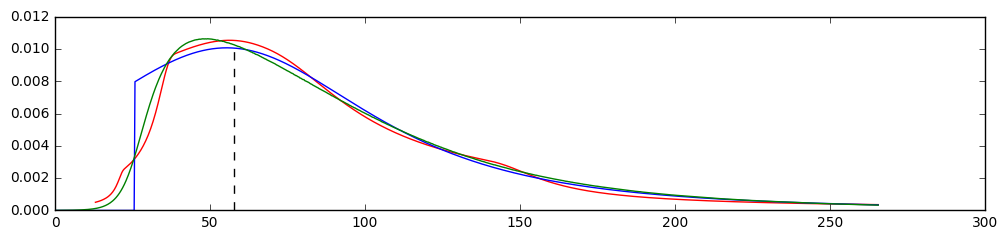

In [17]:
plt.plot(ygrid, pdf(ygrid), color="r")
plt.plot(ygrid, gq_pdf(ygrid), color="b")
plt.plot(ygrid, beta_pdf(ygrid), color="g")
plt.vlines(x=d['inputs']['line_month_ppp'],ymin=0,ymax=themax,linestyle="dashed");

In [18]:
quantile(0.5)

78.13447155082055